### 开始之前先安装好环境，cmd 下面直接安装pytorch  
#### anaconda安装:
```bash
conda install pytorch-cpu -c pytorch 
pip3 install torchvision
```
---
#### pip安装（没有安装anaconda的情况）:
```bash
pip3 install http://download.pytorch.org/whl/cpu/torch-0.4.0-cp36-cp36m-win_amd64.whl 
pip3 install torchvision
pip install numpy
pip install matplotlib
pip install jupyter
```
---
在上面环境安装好之后， 如何运行此程序，切换到`display_0724.ipynb`所在目录下，打开命令行窗口输入：
```bash
jupyter notebook
```
然后会跳转到网页即可开始运行。

![%E5%BE%AE%E4%BF%A1%E6%88%AA%E5%9B%BE_20180722212612.png](attachment:%E5%BE%AE%E4%BF%A1%E6%88%AA%E5%9B%BE_20180722212612.png)

---
### 如何训练一个卷积神经网络对蜜蜂和蚂蚁进行识别？
**[1. 导入依赖库](#1)  
[2. 加载图片数据](#2)  
[3. 显示一些增强后的训练图像（非必须）](#3)  
[4. 设计和选择模型](#4)   
[5. 训练模型](#5)    
[6.测试和评估](#6)**

###  <span id="1">1. 导入依赖库</span>

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()   # interactive mode
%matplotlib inline

### <span id="2">2. 加载图片数据</span>
数据以下面文件夹方式进行排列
- hymenoptera_data
    - train
        - bee (.jpg .jpg .jpb)
        - ant (.jpg .jpg .jpb)
    - val
        - bee (.jpg .jpg .jpb)
        - ant (.jpg .jpg .jpb)
        
数据集下载地址：https://download.pytorch.org/tutorial/hymenoptera_data.zip

In [2]:
# 对数据增强（也就是通过几何变换增大数据集）
# 一般进行随机裁剪，缩放，旋转等方式
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
#        transforms.RandomResizedCrop(224),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
#        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 设置数据集的路径
data_dir = 'hymenoptera_data'
# 读取数据集
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# 把数据分批次，方便神经网络读取
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=1)
              for x in ['train', 'val']}

# 查看数据集大小
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# 查看数据集的类别
class_names = image_datasets['train'].classes

#  是否使用gpu，如果有gpu就用gpu，没有的话就在cpu上跑
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
dataset_sizes

{'train': 244, 'val': 153}

In [4]:
class_names

['ants', 'bees']

### <span id="3">3. 显示一些增强后的训练图像</span>
让我们可视化一些训练图像，以便了解数据增强。

In [5]:
# 这个函数的目的是显示图像
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

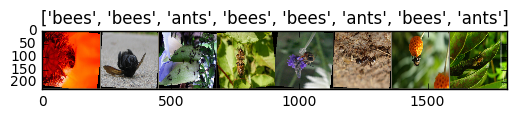

In [6]:
# 加载一个批次的训练数据
inputs, classes = next(iter(dataloaders['train']))

# 网格化输出
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### <span id="4">4. 设计和选择模型</span>
设计模型--卷积神经网络（五个卷积层，两个全连接层）  
卷积层，池化层和全连接层

In [7]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))        
        self.fc1 = nn.Linear(7*7*512, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [8]:
model = ConvNet(num_classes=2).to(device)
model

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): B

### 实例化模型这个类

In [9]:
model = ConvNet(num_classes=2).to(device)
# 选择损失函数
criterion = nn.CrossEntropyLoss()
# 选择优化器
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### <span id="5">5. 训练模型</span>

几个参数的含义：  
epoch：每遍历一次整个训练集称为一个epoch  
learning_rate(图中的α):
![image.png](attachment:image.png)

In [10]:
def train(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    # 训练模型
    total_step = len(dataloaders['train'])
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(dataloaders['train']):
            images = images.to(device)
            labels = labels.to(device)

            # 前向传播
            outputs = model(images)
            # 计算损失
            loss = criterion(outputs, labels)

            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 5 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
      
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    
    
    return model
    
        # 学习率衰减
#     if (epoch+1) % 5 == 0:
#         learning_rate /= 3
#         optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# model.load_state_dict(torch.load('model.ckpt'))
model = train(model, criterion, optimizer, num_epochs=15)

Epoch [1/15], Step [5/31], Loss: 1.5662
Epoch [1/15], Step [10/31], Loss: 0.5918
Epoch [1/15], Step [15/31], Loss: 0.7062
Epoch [1/15], Step [20/31], Loss: 0.6427
Epoch [1/15], Step [25/31], Loss: 0.7690
Epoch [1/15], Step [30/31], Loss: 0.8629
Epoch [2/15], Step [5/31], Loss: 0.6264
Epoch [2/15], Step [10/31], Loss: 0.7066
Epoch [2/15], Step [15/31], Loss: 0.3413
Epoch [2/15], Step [20/31], Loss: 0.7021
Epoch [2/15], Step [25/31], Loss: 0.7594
Epoch [2/15], Step [30/31], Loss: 0.6545
Epoch [3/15], Step [5/31], Loss: 0.8040
Epoch [3/15], Step [10/31], Loss: 0.5848
Epoch [3/15], Step [15/31], Loss: 0.6773
Epoch [3/15], Step [20/31], Loss: 0.4964
Epoch [3/15], Step [25/31], Loss: 0.4973
Epoch [3/15], Step [30/31], Loss: 1.2939
Epoch [4/15], Step [5/31], Loss: 0.4539
Epoch [4/15], Step [10/31], Loss: 0.5971
Epoch [4/15], Step [15/31], Loss: 0.7952
Epoch [4/15], Step [20/31], Loss: 0.6950
Epoch [4/15], Step [25/31], Loss: 0.5651
Epoch [4/15], Step [30/31], Loss: 0.6146
Epoch [5/15], Step [

In [12]:
# 保存模型及其参数
torch.save(model.state_dict(), 'model.ckpt')

### <span id="6">6. 测试和评估</span>

In [13]:
# 测试
def test(model, phase='val'):
    model.eval()
    test_start = time.time()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in dataloaders[phase]:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        time_elapsed = time.time() - test_start
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Test Accuracy of the model on the {0} test images: {1} %'.format(len(image_datasets[phase]), 100 * correct / total))
        

In [14]:
test(model, phase='train') # phase == 'train' or 'val'

Training complete in 1m 49s
Test Accuracy of the model on the 244 test images: 83.19672131147541 %


In [15]:
test(model, phase='val') # phase == 'train' or 'val'

Training complete in 1m 8s
Test Accuracy of the model on the 153 test images: 72.54901960784314 %


In [16]:
# model.load_state_dict(torch.load('model.ckpt'))

### 展示几张图片的预测结果

In [17]:
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloaders['val']):
            images = inputs.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

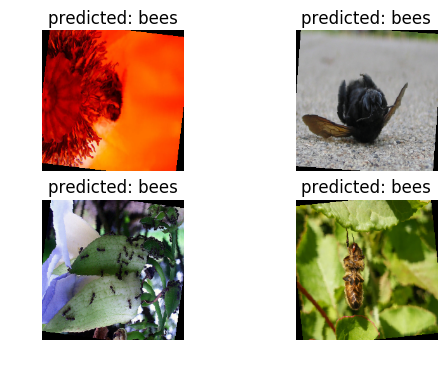

In [18]:
visualize_model(model)

plt.ioff()
plt.show()